In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
import pickle
import json
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score,GridSearchCV
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"]=(20,10)

In [2]:
df1 = pd.read_csv("./data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.groupby("area_type")["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df2 = df1.drop(["area_type","society","balcony","availability"],axis=1)

In [6]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [7]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
df3["bhk"] = df3["size"].apply(lambda x:int(x.split(" ")[0]))
df3.bhk

0        2
1        4
2        3
3        3
4        2
        ..
13315    5
13316    4
13317    2
13318    4
13319    1
Name: bhk, Length: 13246, dtype: int64

In [11]:
df3["bhk"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [12]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [13]:
df3["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [15]:
df3[~df3["total_sqft"].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


In [16]:
def sqft_to_num(x):
    tokens = x.split(" - ")
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [17]:
df4 = df3.copy()
df4["total_sqft"] = df4["total_sqft"].apply(sqft_to_num)

In [18]:
df4

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


In [19]:
df5 = df4.copy()
df5["price_per_sqft"] = df5["price"]*100000/df5["total_sqft"]

In [20]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
len(df5.location.unique())

1304

In [22]:
df5.location = df5.location.apply(lambda x:x.strip())

In [23]:
location_stats = df5.groupby("location")["location"].agg("count").sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [24]:
less_than_10 = location_stats[location_stats<=10]

In [25]:
df5.location = df5.location.apply(lambda x: "other" if x in less_than_10 else x)

In [26]:
len(df5.location.unique())

242

In [27]:
df5.head(20)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [28]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [29]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("location"):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st))&(subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [30]:
df7 = remove_pps_outliers(df6)
df7.shape

(10241, 7)

In [31]:
def plot_scatter(df,location):
    bhk2 = df[(df.location==location)&(df.bhk==2)]
    bhk3 = df[(df.location==location)&(df.bhk==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price_per_sqft,color="blue",label="2 BHK", s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price_per_sqft,marker="+",color="green",label="3 BHK", s=50)
    plt.xlabel("Total Sqft Area")
    plt.ylabel("Price/sqft")
    plt.title(location)
    plt.legend()

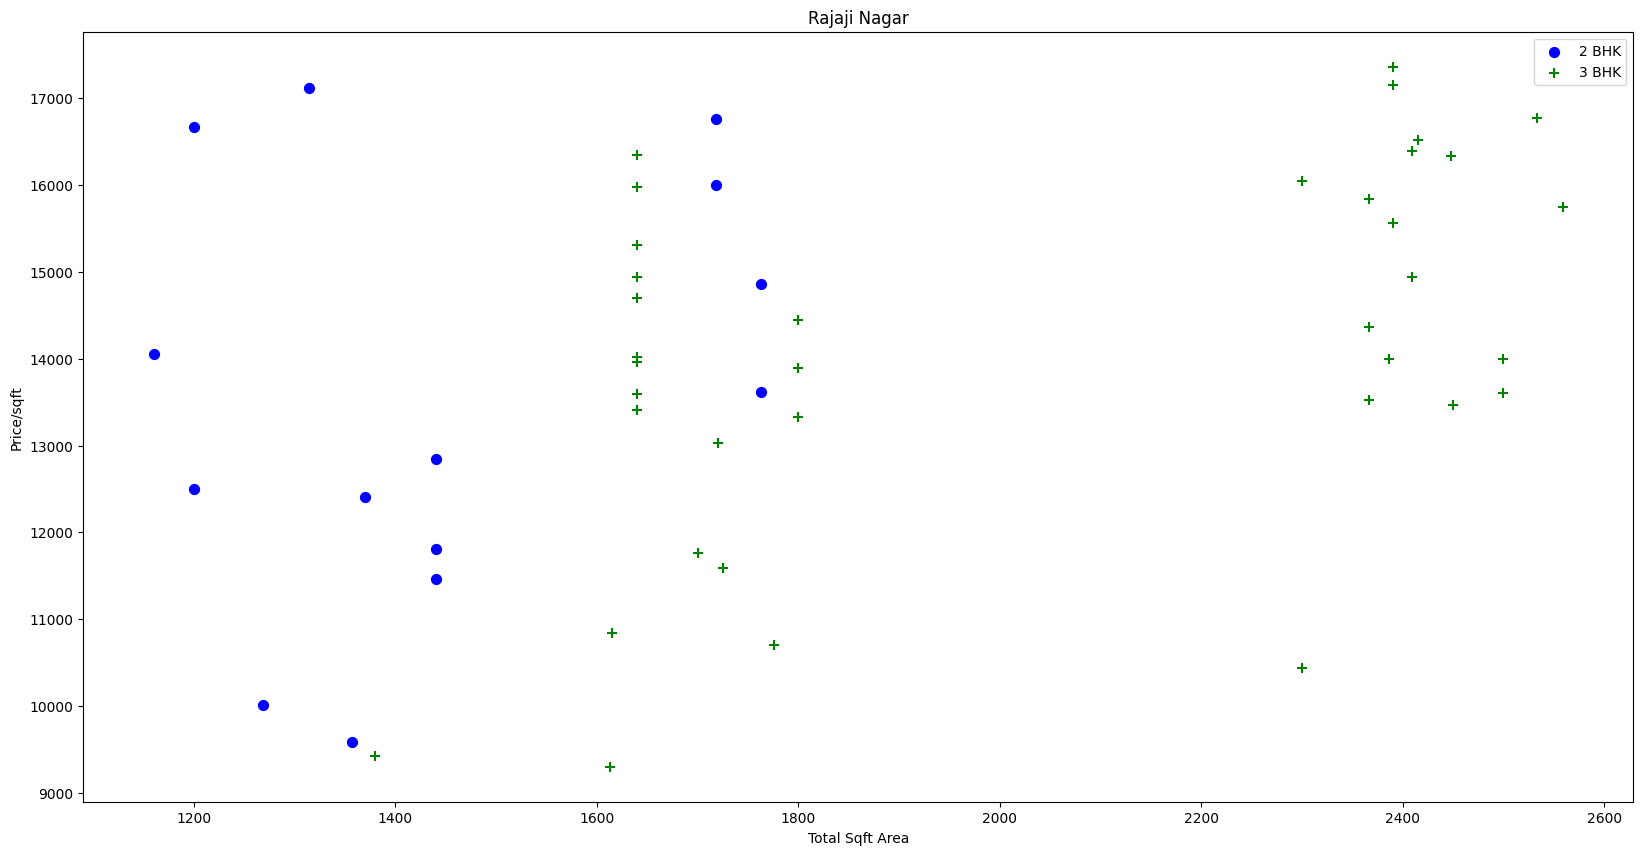

In [32]:
plot_scatter(df7,"Rajaji Nagar")

In [33]:
def remove_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby("bhk"):
            bhk_stats[bhk]={
                "mean":np.mean(bhk_df.price_per_sqft),
                "std":np.std(bhk_df.price_per_sqft),
                "count":bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk-1)
            if stats and stats["count"]>5:
                exclude_indices = np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft<(stats["mean"])].index.values)
    return df.drop(exclude_indices,axis="index")

In [34]:
df8 = remove_outliers(df7)
df8

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10232,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10233,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10236,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10237,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


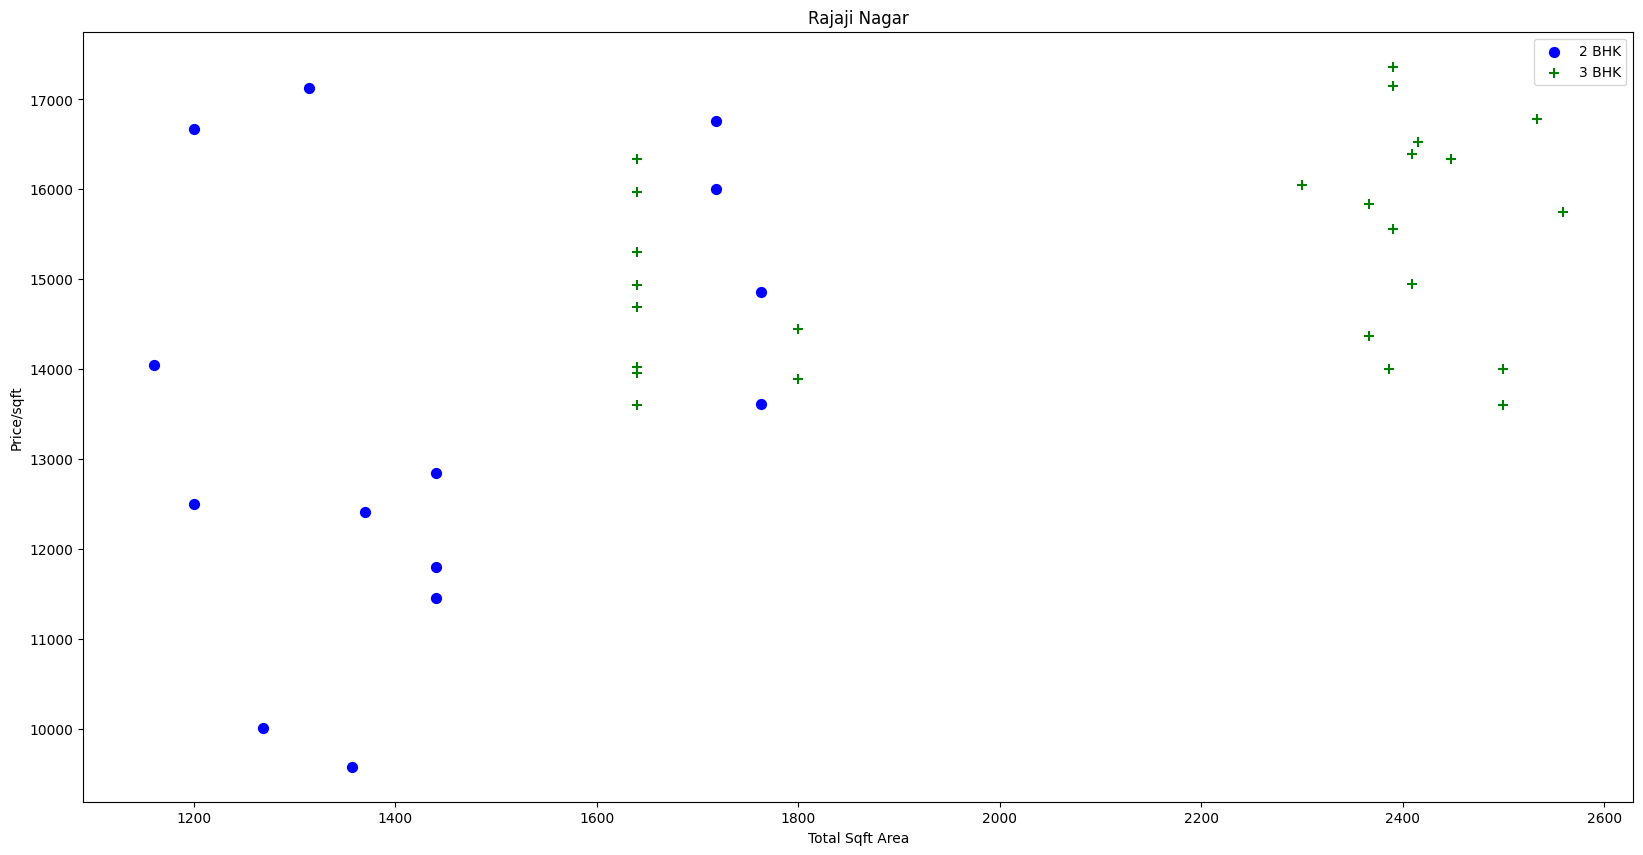

In [35]:
plot_scatter(df8,"Rajaji Nagar")

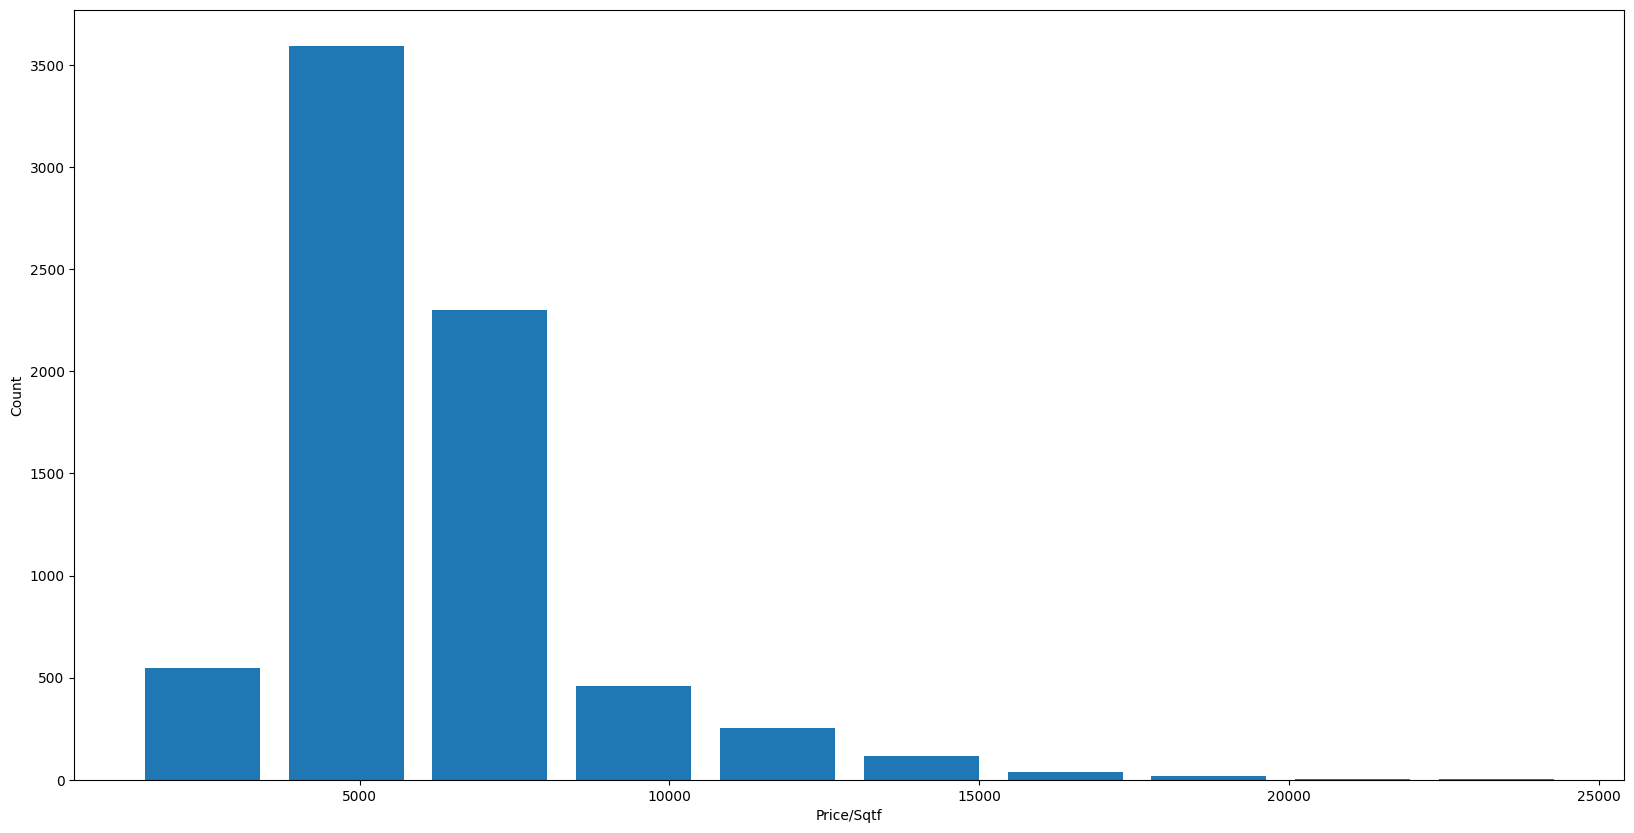

In [36]:
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price/Sqtf")
plt.ylabel("Count")
plt.show();

In [37]:
df9 = df8[df8.bath<df8.bhk+2]
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [38]:
df10 = df9.drop(["size","price_per_sqft"],axis=1)

In [39]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7251 entries, 0 to 10240
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    7251 non-null   object 
 1   total_sqft  7251 non-null   float64
 2   bath        7251 non-null   float64
 3   price       7251 non-null   float64
 4   bhk         7251 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 339.9+ KB


In [40]:
dummies = pd.get_dummies(df10.location)
dummies

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10233,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10236,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10237,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [41]:
df11 = pd.concat([df10,dummies.drop("other",axis=1)],axis=1)

In [42]:
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
df12 = df11.drop("location",axis=1)
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,235.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,130.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,148.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
df12.shape

(7251, 245)

In [45]:
x = df12.drop("price",axis=1)
y = df12.price

In [46]:
np.random.seed(21)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.26,random_state=10)

In [47]:
lr = LinearRegression()
lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.8811132946844935

In [48]:
cv = ShuffleSplit(n_splits=5,test_size=0.26,random_state=100)
cross_val_score(LinearRegression(),x,y,cv=cv)

array([0.81707667, 0.88198711, 0.81263512, 0.79517994, 0.84216184])

In [49]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'copy_X' : [True, False],
                'fit_intercept' : [True, False],
                'n_jobs' : [1,2,3],
                'positive' : [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [50]:
find_best_model_using_gridsearchcv(x,y)

,model,best_score,best_params
0,linear_regression,0.819001,"{'copy_X': True, 'fit_intercept': False, 'n_jo..."
1,lasso,0.687464,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.715887,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [51]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [52]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(x.columns==location)[0][0]
    X = np.zeros(len(x.columns))
    X[0] = sqft
    X[1] = bath
    X[2] = bhk
    if loc_index>=0:
        X[loc_index] = 1
    return lr.predict([X])[0]

In [53]:
predict_price("1st Phase JP Nagar",2000,3,3)

172.07576367985791

In [54]:
predict_price("Indira Nagar",2000,3,3)

259.1472237227135

In [55]:
with open("house_price.pickle","wb") as f:
    pickle.dump(lr,f)

In [56]:
columns = {
    "data_columns":[col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    json.dump(columns, f)